In [1]:
import sys, os, imp
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.constants import c

C:\Users\alves\AppData\Local\Temp\ipykernel_13692\3705448658.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import sys, os, imp


In [2]:
lumapiFile = "/opt/lumerical/v221/api/python/lumapi.py"
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
lumapi = imp.load_source("lumapi", lumapiFile)
interApi = lumapi.INTERCONNECT(hide = False)

In [3]:
interApi.expressioncheckoff()

In [44]:
# units
um = 1e-6
nm = 1e-9

Lc = 10.53*um
lr = np.array([552.82, 55.28, 27.64])*um

wavelength = 1550*nm

# index
neff = 2.3531702
ng = 4.3458796

wvlngth_start = 1.500 * um
wvlngth_stop = 1.600 * um

number_of_points = 50e3

# Simulation

## Add ONA

In [5]:
interApi.switchtolayout()
interApi.select('ONA')
interApi.delete()

# ONA

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.set('number of input ports', 2)
interApi.set('input parameter', 2)
interApi.set('start frequency', c/wvlngth_start)
interApi.set('stop frequency', c/wvlngth_stop)
interApi.set('number of points', number_of_points)

## $FSR(\lambda)=1nn$

In [46]:
interApi.switchtolayout()
interApi.select('coupler_1')
interApi.delete()
interApi.select('coupler_2')
interApi.delete()
interApi.select('wg_1')
interApi.delete()
interApi.select('wg_2')
interApi.delete()

# Waveguide

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', 'coupler_1')
interApi.set('coupling_length', Lc)

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', 'coupler_2')
interApi.set('coupling_length', Lc)

radius = interApi.get('radius')

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', 'wg_1')
interApi.set('wg_length', lr[0]/2 - (np.pi*radius + Lc))
interApi.set('Rotated', 45)
# interApi.set('wg_width', wvg_width)


interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', 'wg_2')
interApi.set('wg_length', lr[0]/2 - (np.pi*radius + Lc))
interApi.set('Rotated', 45)
# interApi.set('wg_width', wvg_width)

In [47]:
#positions
interApi.setposition('ONA', -10, -600)
interApi.setposition('wg_1', 10,-100)
interApi.setposition('wg_2', 300, -100)
interApi.setposition('coupler_1', 200, 300)
interApi.setposition('coupler_2', 200, -300)

In [48]:
# connection

interApi.connect("ONA", "output", "coupler_1", "opt_2")
interApi.connect("coupler_1", "opt_1", "wg_1", "port 2")
interApi.connect("coupler_1", "opt_3", "wg_2", "port 2")
interApi.connect("wg_1", "port 1", "coupler_2", "opt_2")
interApi.connect("wg_2", "port 1", "coupler_2", "opt_4")
interApi.connect("coupler_2", "opt_1", "ONA", "input 1")
interApi.connect("coupler_1", "opt_4", "ONA", "input 2")

1.0

In [49]:
interApi.run()

In [50]:
gain_1nm = interApi.getresult("ONA", "input 1/mode 1/gain")
wavelength_1 = gain_1nm['wavelength']
gain = gain_1nm["'TE' gain (dB)"]

gain_2_1nm = interApi.getresult("ONA", "input 2/mode 1/gain")
wavelength_2 = gain_2_1nm['wavelength']
gain_2 = gain_2_1nm["'TE' gain (dB)"]

C:\Users\alves\AppData\Local\Temp\ipykernel_13692\885390661.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(1547, -20, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)


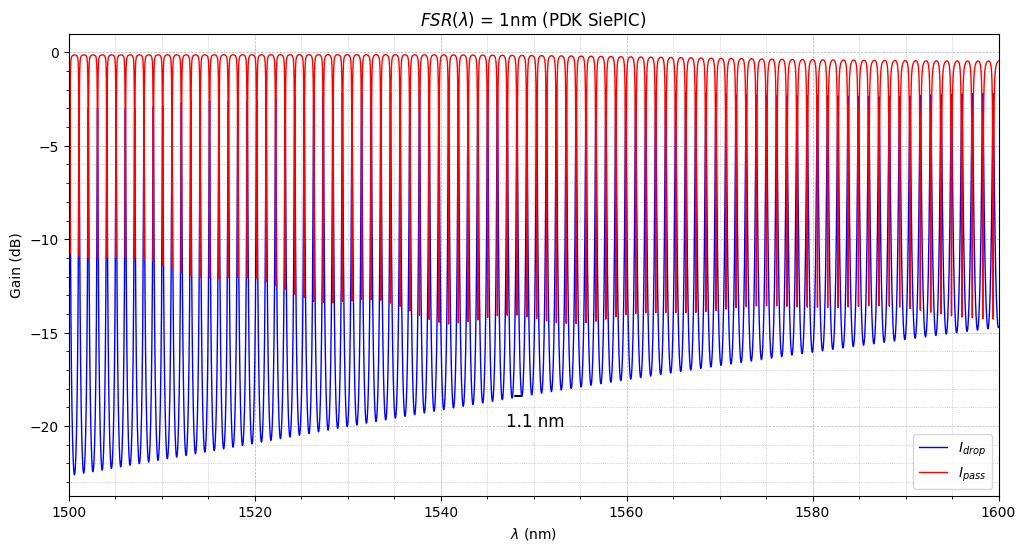

In [57]:
min_indices, _ = find_peaks(-np.array(gain))

if len(min_indices) >= 2:
    min_1, min_2 = min_indices[47:49]  
    x_min_1, x_min_2 = wavelength_1[min_1] / nm, wavelength_1[min_2] / nm
    y_min = gain[min_1]

    plt.figure(figsize=(12, 6))
    plt.plot(wavelength_1 / nm, gain, lw=1, label='$I_{drop}$', color='blue')
    plt.plot(wavelength_2 / nm, gain_2, lw=1, label='$I_{pass}$', color='red')

    plt.hlines(y=y_min, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
    plt.text(1547, -20, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)

    plt.xlabel('$\lambda$ (nm)')
    plt.ylabel('Gain (dB)')
    plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
    plt.title('$FSR(\lambda)$ = 1nm (PDK SiePIC)')
    plt.minorticks_on()
    plt.grid(which='both', linestyle='--', linewidth=0.5)  
    plt.grid(which='minor', linestyle=':', linewidth=0.5) 

    plt.legend(loc='best')
    plt.savefig('FSR_1nm_PDK', bbox_inches='tight')
    plt.show()

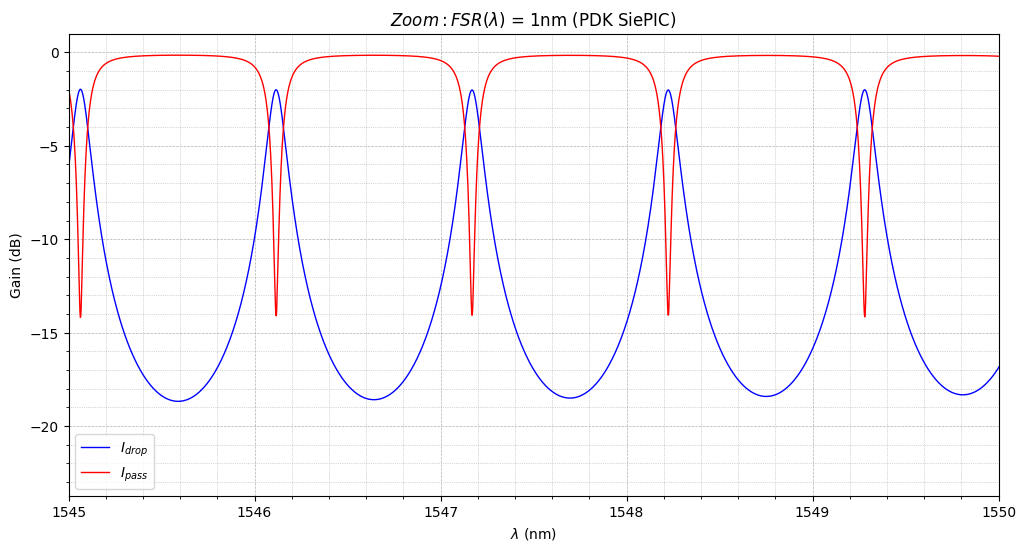

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, gain, lw=1, label='$I_{drop}$', color='blue')
plt.plot(wavelength_2 / nm, gain_2, lw=1, label='$I_{pass}$', color='red')

# plt.hlines(y=y_min, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
# plt.text(1550, -22, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Gain (dB)')
plt.xlim([1545, 1550])
    
plt.title('$Zoom: FSR(\lambda)$ = 1nm (PDK SiePIC)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_1nm_PDK_zoom', bbox_inches='tight')
plt.show()